# Topic Modeling
### ... in a nutshell:

<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

In [59]:
import sys
import re, numpy as np
from pprint import pprint

We will need to draw some plots:

In [60]:
! pip install matplotlib

In [63]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

We again use Gensim library, but now we work with its topic modelling features.

In [61]:
# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

NLTK toolkit provides us with a corpus and additional tools:

In [62]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [64]:
# Import Dataset
import nltk 
nltk.download('gutenberg')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to C:\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let us take Lewis Carroll's "Alice in Wonderland" and preprocess it:

In [65]:
alice = nltk.corpus.gutenberg.sents('carroll-alice.txt')

In [66]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(alice, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[alice], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [67]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(alice)  # processed Text Data!

In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.024*"slate" + 0.022*"never" + 0.018*"hatter" + 0.017*"gave" + 0.017*"way" '
  '+ 0.016*"march" + 0.016*"hand" + 0.016*"hare" + 0.015*"hear" + '
  '0.013*"around"'),
 (1,
  '0.122*"said" + 0.042*"alice" + 0.026*"change" + 0.026*"eye" + 0.023*"long" '
  '+ 0.018*"simple" + 0.018*"child" + 0.017*"head" + 0.014*"day" + '
  '0.014*"must"'),
 (2,
  '0.035*"little" + 0.023*"turtle" + 0.022*"mock" + 0.019*"pig" + 0.018*"jury" '
  '+ 0.017*"knew" + 0.017*"time" + 0.014*"sob" + 0.014*"alice" + 0.012*"half"'),
 (3,
  '0.054*"king" + 0.043*"queen" + 0.034*"voice" + 0.026*"rabbit" + '
  '0.026*"white" + 0.023*"one" + 0.018*"shrill" + 0.015*"teacup" + 0.014*"air" '
  '+ 0.014*"first"')]


Let us see on the corpus and output model more precisely:

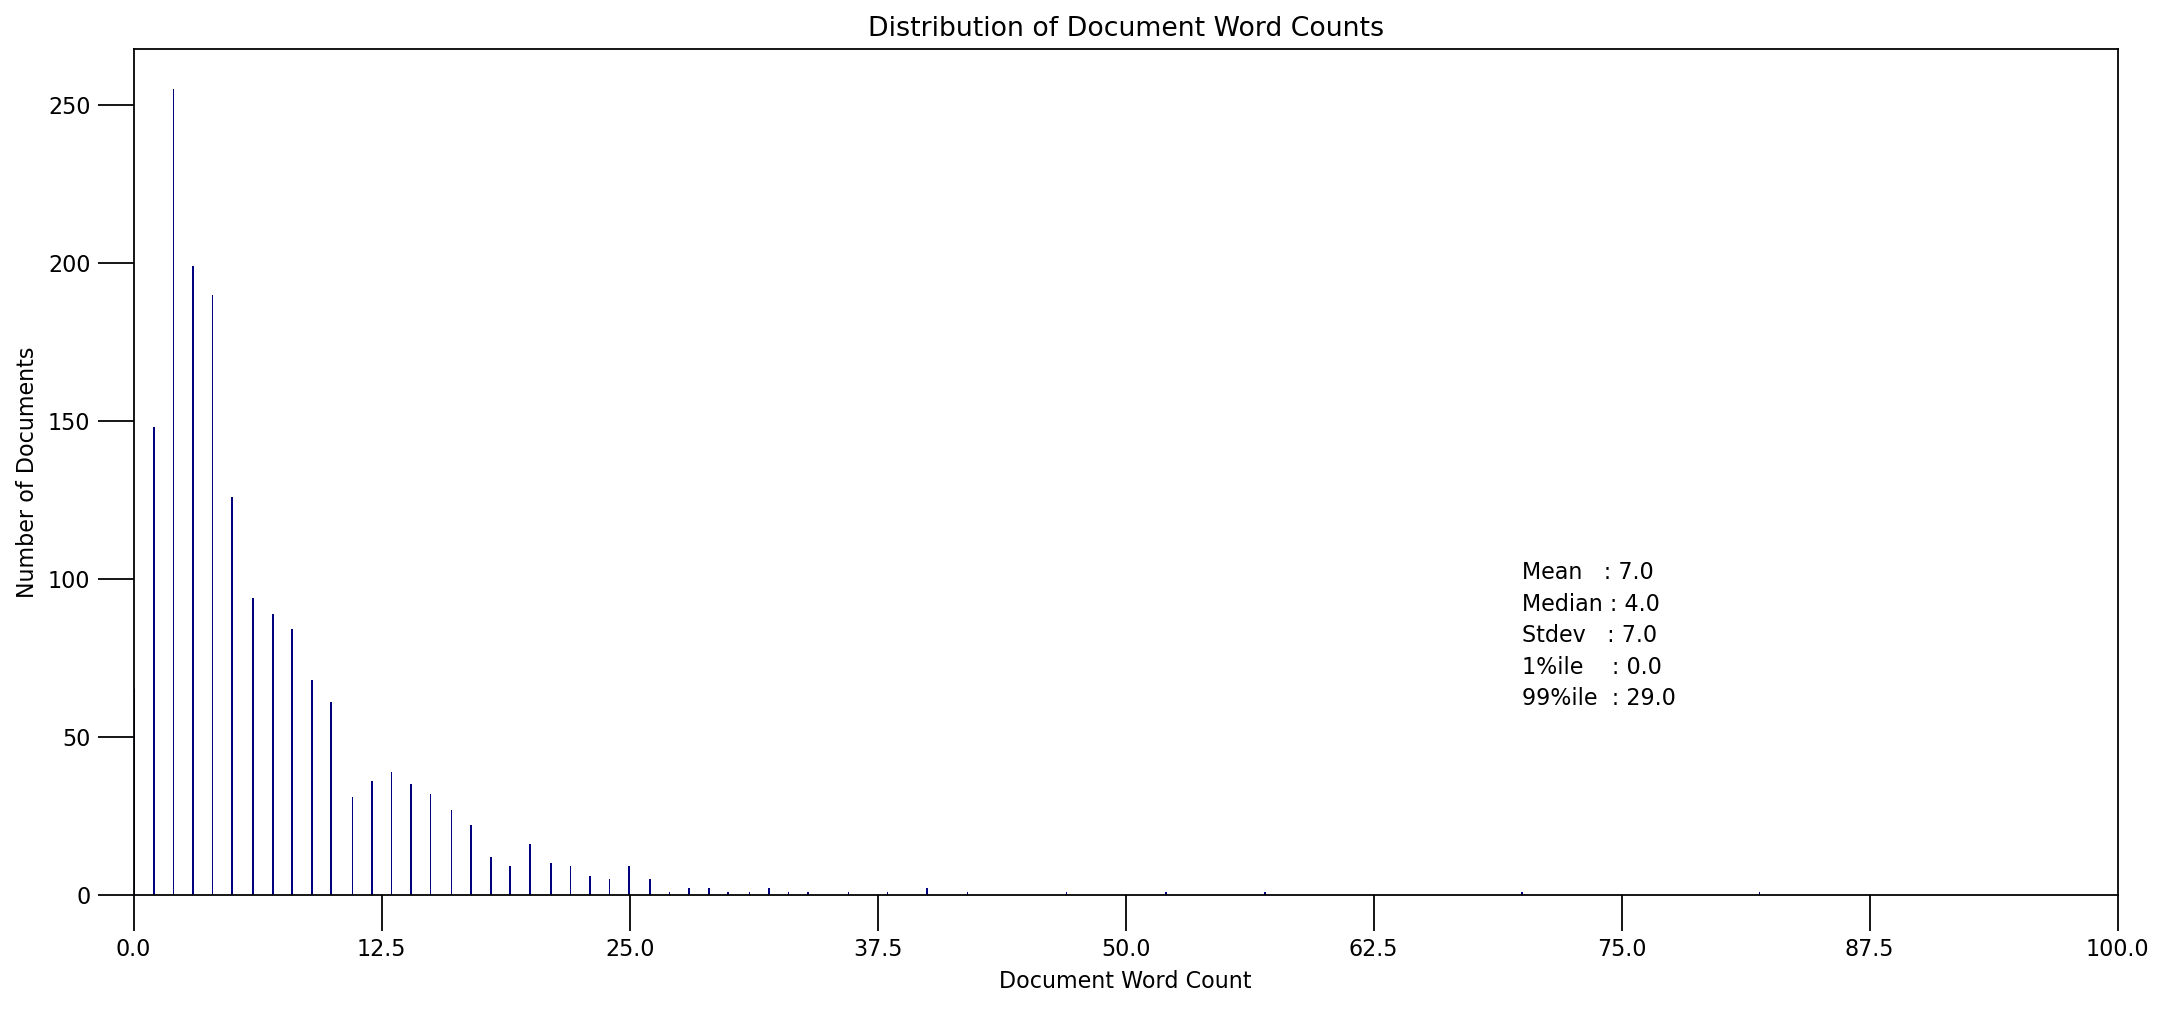

In [70]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [71]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

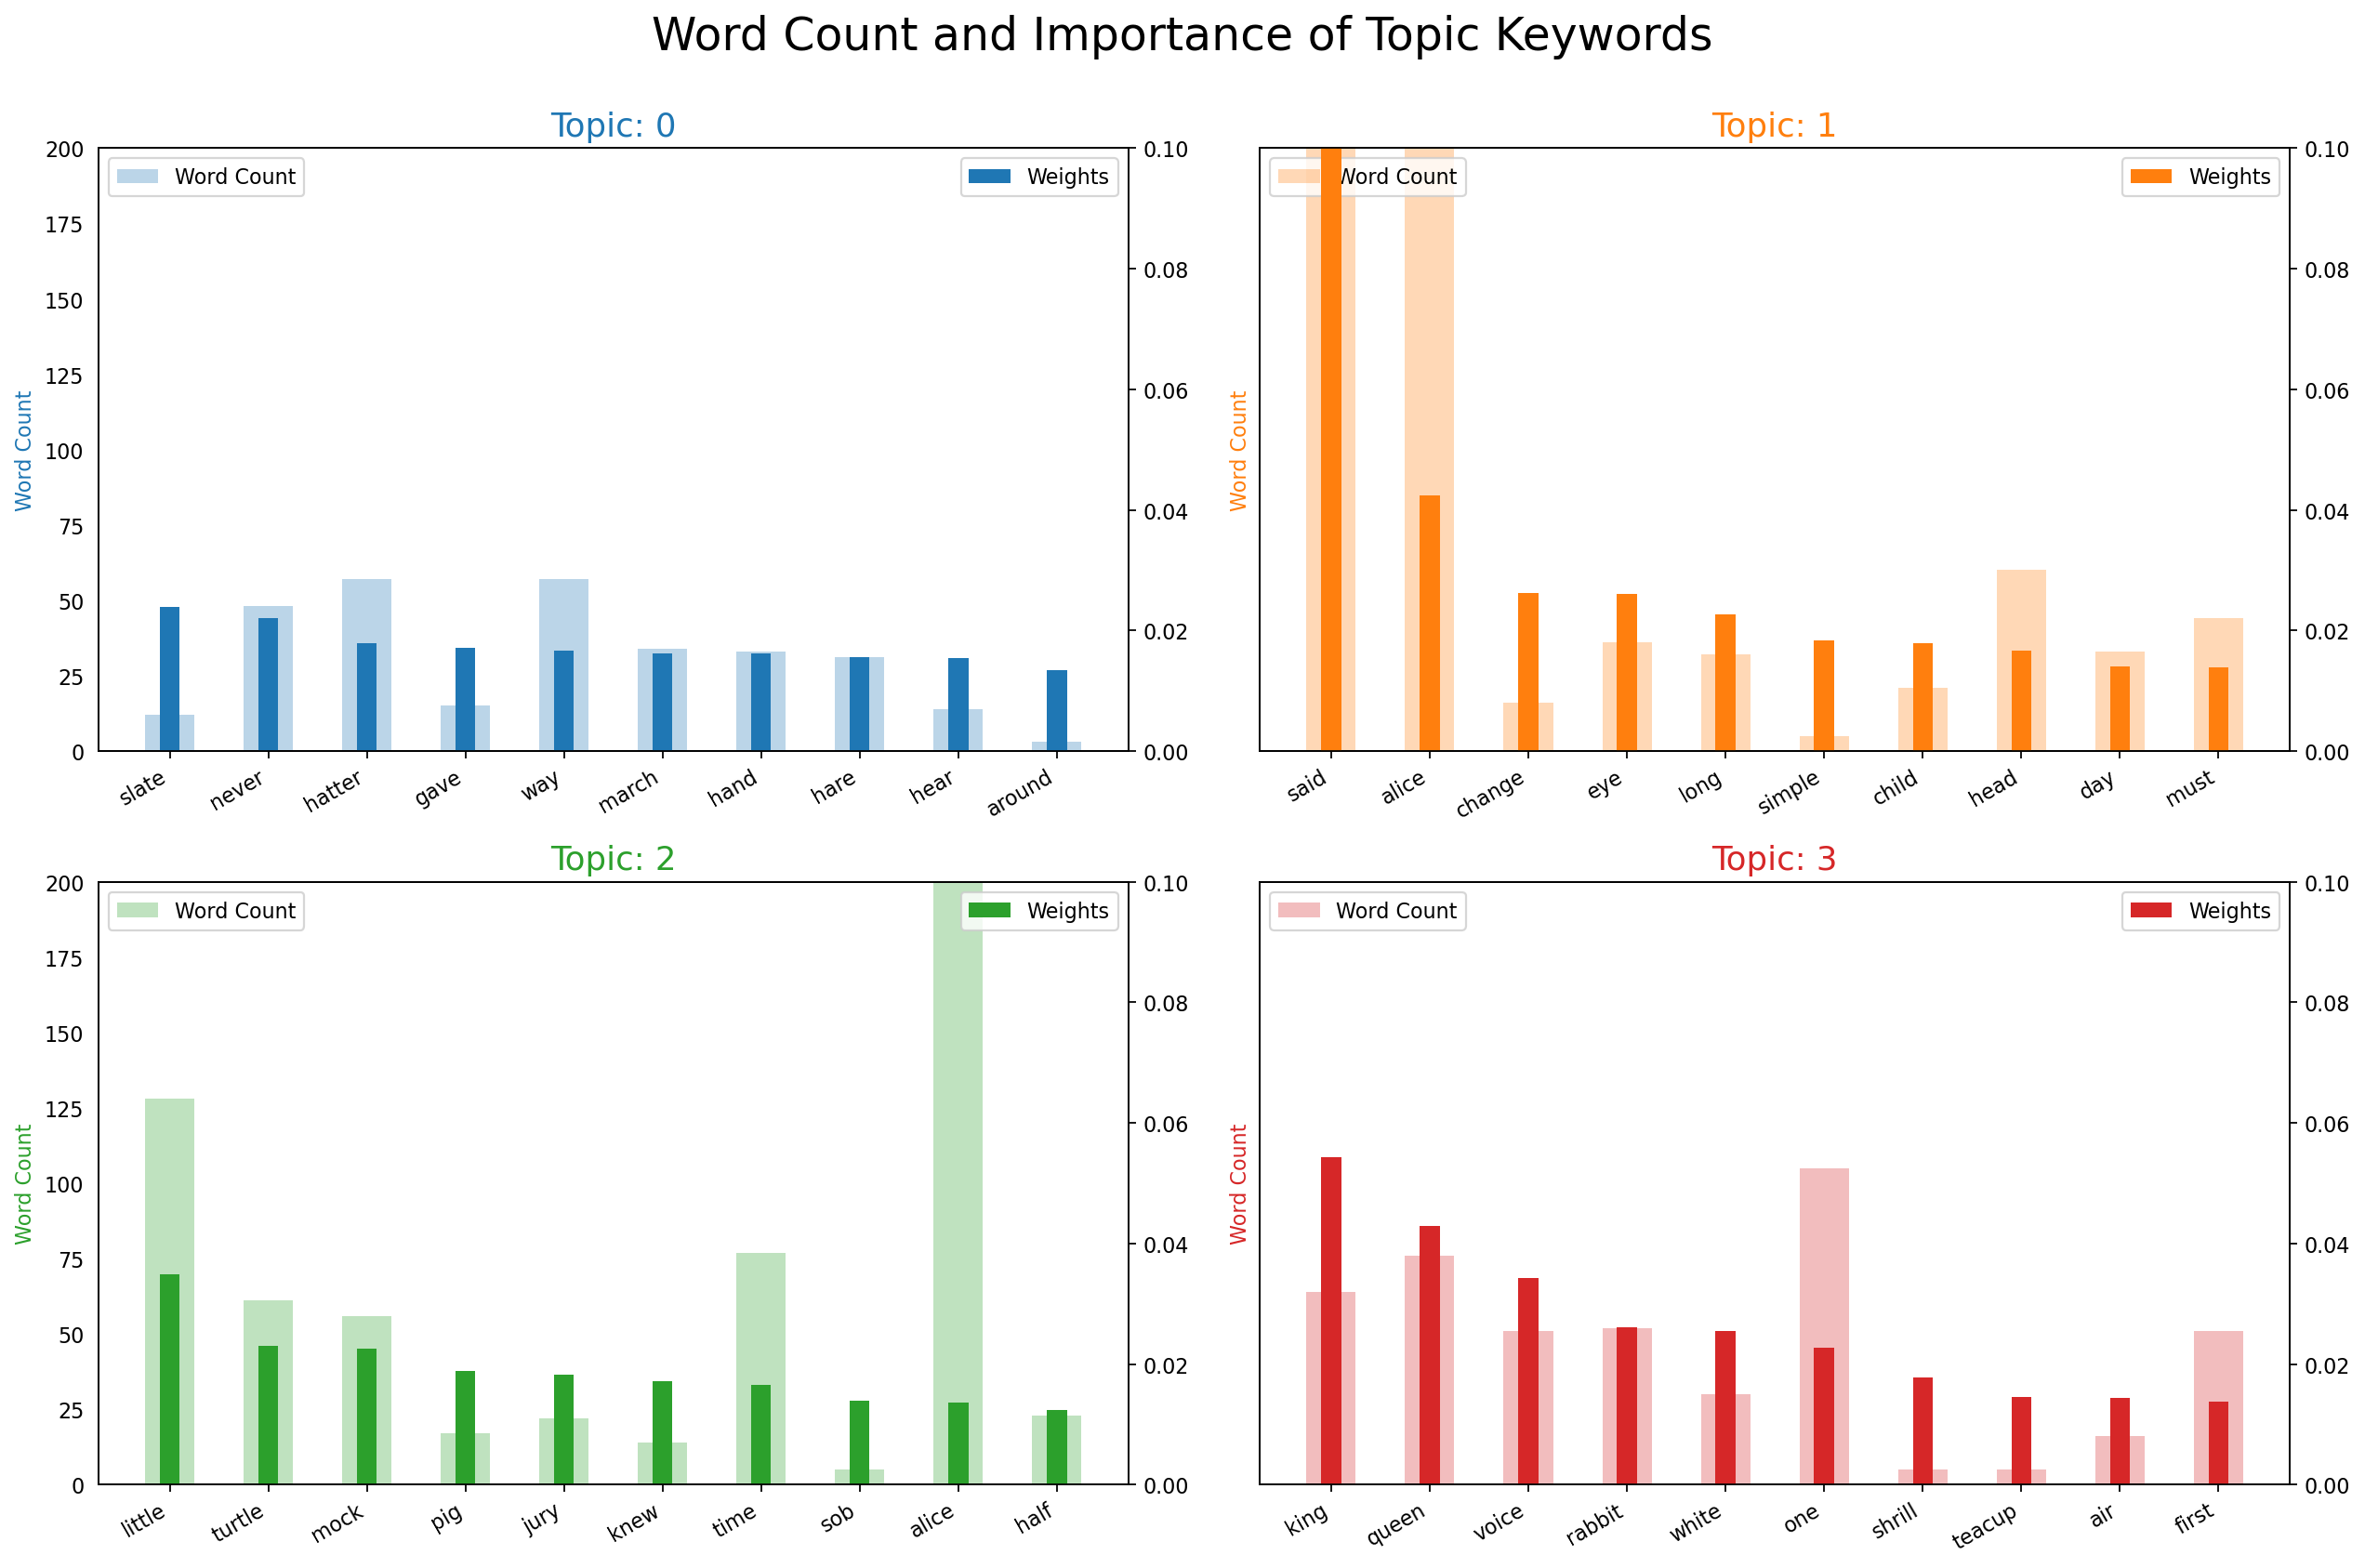

In [72]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [73]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

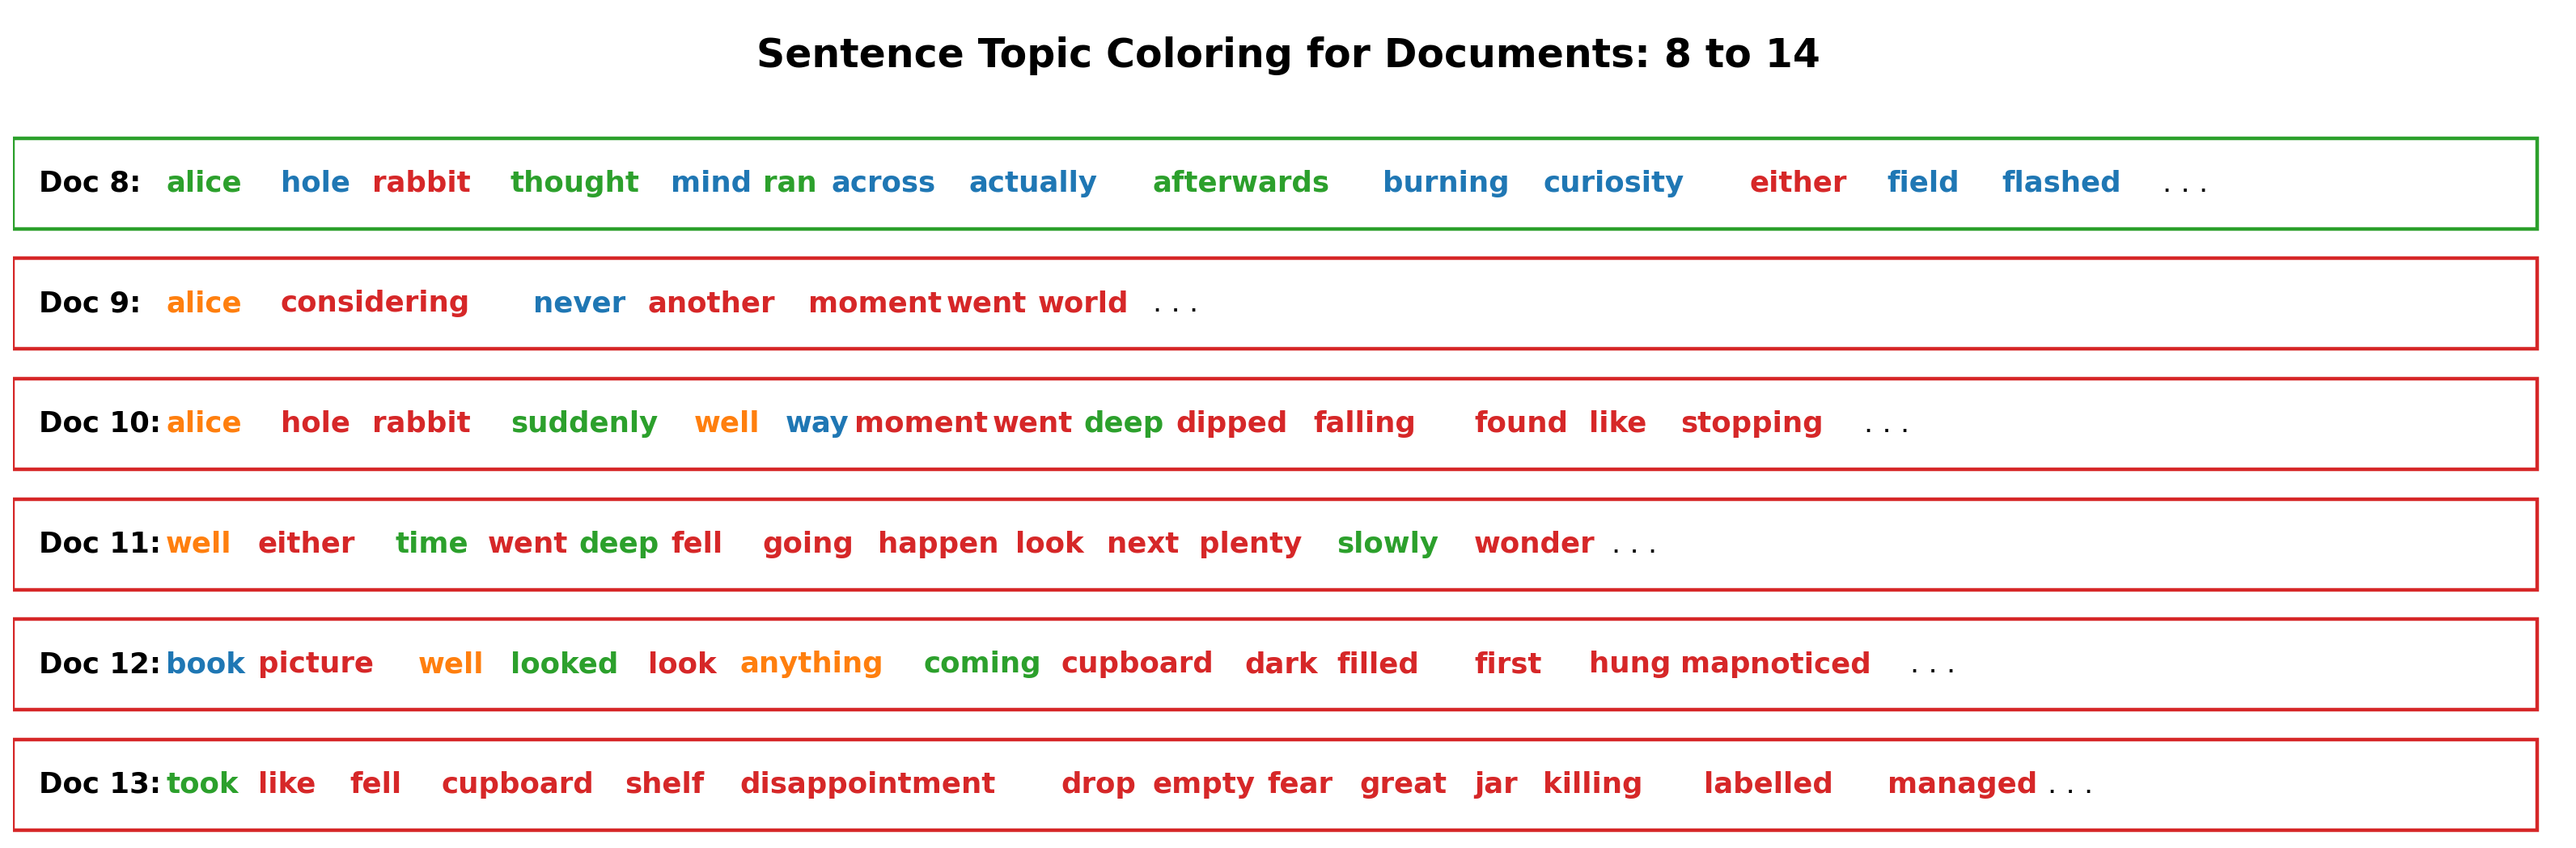

In [74]:
sentences_chart(start=8, end=15)  

For the final part we need an additional tool for visualization:

In [75]:
! pip install pyldavis

In [76]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.243605  0.057295       1        1  28.043159
3      0.131519 -0.170337       2        1  25.364927
2     -0.048527 -0.087041       3        1  24.089861
0      0.160614  0.200083       4        1  22.502045, topic_info=           Term        Freq       Total Category  logprob  loglift
147        said  388.000000  388.000000  Default  30.0000  30.0000
1677       king  157.000000  157.000000  Default  29.0000  29.0000
1353      queen  124.000000  124.000000  Default  28.0000  28.0000
205      little   95.000000   95.000000  Default  27.0000  27.0000
533       voice   99.000000   99.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1699       knee   26.770061   45.038101   Topic4  -4.5579   0.9713
464        life   19.361601   28.751190   Topic4  -4.8819   1.0962
2075  miserable   18.982210   31.281677   Topic4  -4.9016   0.9920
2016      court   19.196377   44.340012   Topic4  -4.8904   0.6544
2043     teacup   19.405527   61.974457   Topic4  -4.8796   0.3304

[196 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
891       1  0.987123       added
196       2  0.977470         air
1         1  0.782022       alice
1         3  0.214332       alice
1963      1  0.026211      around
...     ...       ...         ...
4         3  0.450400  wonderland
4         4  0.020473  wonderland
176       1  0.992168        word
1549      4  0.970431     writing
688       4  0.988657         yet

[259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])